# Forward model

In [151]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

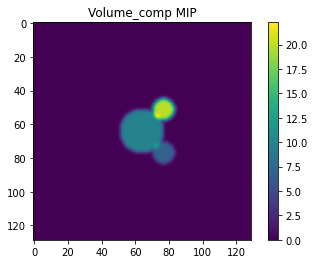

In [153]:
shape = np.array([129,129,129])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))

mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Vol FFT slice')

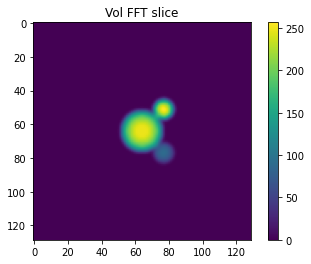

In [154]:
angles = jnp.array([0,0,0])

v_slice = project_spatial(v, angles, dimensions)

plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

In [155]:
@jax.jit
def slice_func(angles):
    return project_spatial(v, angles, dimensions)

@jax.jit
def slice_func_array(angles):
    return jnp.apply_along_axis(slice_func, 1, angles)

In [157]:
angles = jnp.array([np.pi,np.pi/3*2,np.pi/4])

start = time.time()
s1 = slice_func(angles)
print(time.time()-start)

start = time.time()
s2 = slice_func_array(jnp.array([angles]))
print(time.time()-start)

0.07115912437438965
0.05743265151977539


In [159]:
angles_true = jnp.array(np.random.rand(100,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(angles_true)
print(time.time()-start)

imgs.shape

0.21299505233764648


(100, 129, 129)

In [160]:
@jax.jit
def loss_func(a):
    return 1/(2* 16641) * jnp.sum((slice_func(a) - img1)**2)

def loss_func_array(a):
    return 1/(2 * 16641 * angles_true.shape[0]) * jnp.sum((slice_func_array(a) - imgs)**2)

dloss = jax.jit(jax.grad(loss_func_array))

In [163]:
start = time.time()
loss_func_array(angles_true)
print(time.time()-start)

0.24547529220581055


In [164]:
start = time.time()
dloss(angles_true)
print(time.time()-start)

0.4412417411804199


In [169]:
#a0 = jnp.array(np.random.rand(1000,3))*jnp.pi*2
a0 = jnp.array(angles_true) + 0.1
alpha = 0.01
a = a0
iters = 20
for i in range(iters):
    #if np.mod(i,100) == 0:
        #print(i)
    print(str(i) + ": loss = " + str(loss_func_array(a)))

    a = a - alpha * dloss(a)

0: loss = 21.49718276612256
1: loss = 12.777747623547032
2: loss = 7.747072292184161
3: loss = 5.039004499335535
4: loss = 3.52640674075364
5: loss = 2.6882011639949615
6: loss = 2.1842454448572832
7: loss = 1.8467778987812757
8: loss = 1.5989674937790697
9: loss = 1.4124370060680909
10: loss = 1.2660611540184359
11: loss = 1.147842545766236
12: loss = 1.0516884326626217
13: loss = 0.9702219397872782
14: loss = 0.9025442639934452
15: loss = 0.8446047895331658
16: loss = 0.794128470232913
17: loss = 0.7498008480034444
18: loss = 0.7105851693363342
19: loss = 0.6754618779242313


In [170]:
jnp.max(a - jnp.array(angles_true))

DeviceArray(0.11570363, dtype=float64)

## Nearest neighbour interpolation

0.44780898094177246


Text(0.5, 1.0, 'NN')

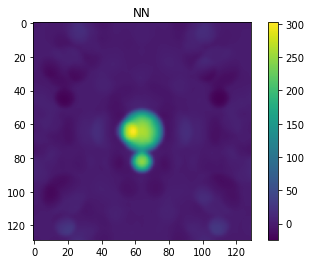

In [201]:
start = time.time()
slice_nn = project_spatial(v, angles, dimensions, "nn")
print(time.time()-start)


plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")